In [14]:
import pandas as pd
from datamodel import OrderDepth, UserId, TradingState, Order
from typing import List
import numpy as np
from statistics import NormalDist
import json
from typing import Any
from datamodel import Listing, Observation, Order, OrderDepth, ProsperityEncoder, Symbol, Trade, TradingState
from matplotlib import pyplot as plt
files = ['prices_round_3_day_2.csv',
         'prices_round_3_day_1.csv',
                'prices_round_3_day_0.csv',]

vouchers = ['VOLCANIC_ROCK_VOUCHER_9500',
            'VOLCANIC_ROCK_VOUCHER_9750',
            'VOLCANIC_ROCK_VOUCHER_10000',
            'VOLCANIC_ROCK_VOUCHER_10250',
            'VOLCANIC_ROCK_VOUCHER_10500',]
rock = "VOLCANIC_ROCK"

In [38]:
voucher_prices = {'VOLCANIC_ROCK_VOUCHER_9500':{},
            'VOLCANIC_ROCK_VOUCHER_9750':{},
            'VOLCANIC_ROCK_VOUCHER_10000':{},
            'VOLCANIC_ROCK_VOUCHER_10250':{},
            'VOLCANIC_ROCK_VOUCHER_10500':{}}

def tte(t, d):
    return float(((8-float(d))/8) - ((float(t)/1000000)/8))

rock_prices = {}
for file in files:
    df = pd.read_csv(file, sep=';')
    for index, row in df.iterrows():
        t=int(row['timestamp'])
        d=int(row['day'])
        if row['product'] in vouchers:
            if pd.notna(row['bid_price_1']) and pd.notna(row['ask_price_1']):
                mid=(int(row['bid_price_1'])+int(row['ask_price_1']))/2
                voucher_prices[row['product']][(t,d)] = mid
        elif row['product'] == rock:
            if pd.notna(row['bid_price_1']) and pd.notna(row['ask_price_1']):
                mid=(int(row['bid_price_1'])+int(row['ask_price_1']))/2
                rock_prices[(t,d)] = mid

In [39]:
for v in voucher_prices.keys():
    if voucher_prices[v] == []:
        print(v)

In [40]:
class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (
            volatility * np.sqrt(time_to_expiry)
        )
        d2 = d1 - volatility * np.sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = (np.log(spot / strike) + (0.5 * volatility * volatility) * time_to_expiry) / (
            volatility * np.sqrt(time_to_expiry)
        )
        d2 = d1 - volatility * np.sqrt(time_to_expiry)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        return NormalDist().pdf(d1) / (spot * volatility * np.sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        # print(f"d1: {d1}")
        # print(f"vol: {volatility}")
        # print(f"spot: {spot}")
        # print(f"strike: {strike}")
        # print(f"time: {time_to_expiry}")
        return NormalDist().pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10
    ):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [41]:
def calculate_moneyness(strike, spot, tte):
        return (np.log(strike)-np.log(spot))/np.sqrt(tte)

In [42]:
# Calculate moneyness and IV for all data points
v_t_values = {v:[] for v in vouchers}
m_t_values = {v:[] for v in vouchers}

for voucher_name, prices in voucher_prices.items():
    try:
        strike = int(voucher_name.split('_')[-1])
    except:
        continue
    
    for (t, d), Vt in prices.items():
        if (t, d) in rock_prices:
            St = rock_prices[(t, d)]
            
            # Calculate metrics
            m_t = calculate_moneyness(strike, St, tte(t, d))
            try:
                v_t = BlackScholes.implied_volatility(Vt, St, strike, tte(t, d))
                if(v_t<0.015): continue
                m_t_values[voucher_name].append(m_t)
                v_t_values[voucher_name].append(v_t)
            except:
                continue

In [43]:
for v in m_t_values.keys():
    if m_t_values[v] == []:
        print(v)

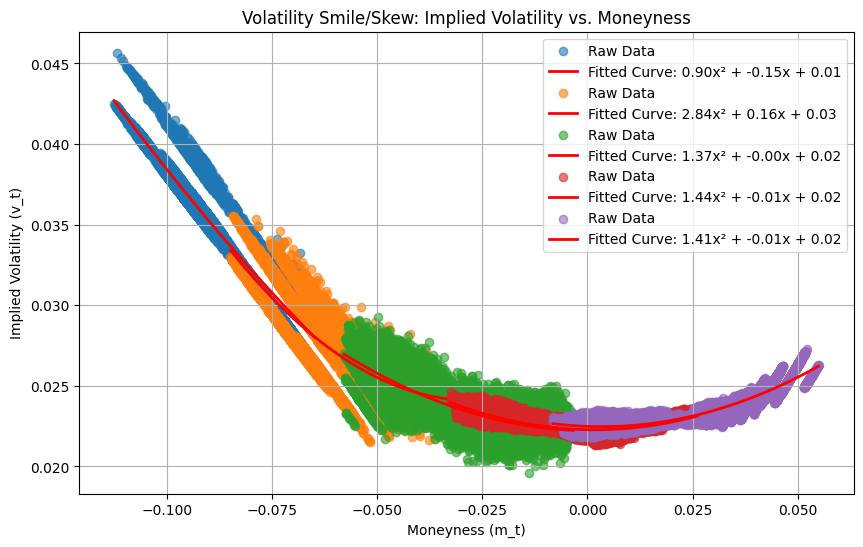

In [44]:
plt.figure(figsize=(10, 6))
equations = {v:[] for v in vouchers}
for v in vouchers:
    # Fit quadratic curve
    coefficients = np.polyfit(m_t_values[v], v_t_values[v], 2)
    equations[v] = coefficients
    poly_fit = np.poly1d(coefficients)

    # Generate points for smooth curve
    m_range = np.linspace(min(m_t_values[v]), max(m_t_values[v]), 100)
    v_fit = poly_fit(m_range)

    # Plot results
    plt.scatter(m_t_values[v], v_t_values[v], alpha=0.6, label='Raw Data')
    plt.plot(m_range, v_fit, 'r-', lw=2, label=f'Fitted Curve: {coefficients[0]:.2f}x² + {coefficients[1]:.2f}x + {coefficients[2]:.2f}')
plt.title('Volatility Smile/Skew: Implied Volatility vs. Moneyness')
plt.xlabel('Moneyness (m_t)')
plt.ylabel('Implied Volatility (v_t)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
print(equations)

{'VOLCANIC_ROCK_VOUCHER_9500': [], 'VOLCANIC_ROCK_VOUCHER_9750': [], 'VOLCANIC_ROCK_VOUCHER_10000': [], 'VOLCANIC_ROCK_VOUCHER_10250': [], 'VOLCANIC_ROCK_VOUCHER_10500': []}


In [22]:
for v in vouchers:
    print(v, np.std(v_t_values[v]))

VOLCANIC_ROCK_VOUCHER_9500 0.003673024730847294
VOLCANIC_ROCK_VOUCHER_9750 0.002606121871391163
VOLCANIC_ROCK_VOUCHER_10000 0.001551484610534744
VOLCANIC_ROCK_VOUCHER_10250 0.0005044560311956862
VOLCANIC_ROCK_VOUCHER_10500 0.0010040227501279812


In [ ]:
plt.plot()